In [103]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal,StaticGraphTemporalSignal

from Trainer_loocv import Trainer
from utils_temporal import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from sklearn.preprocessing import LabelEncoder


%config InlineBackend.figure_format = 'retina'


In [104]:
df = pd.read_csv('data/final_data_mar.csv.gz')

In [105]:
df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,0.0,18.0,64.0,7.56,13.0,False
2,2014-05-01 02:00:00,1002,116.20531,40.00395,88.0,0.0,18.0,70.0,5.76,13.0,False
3,2014-05-01 03:00:00,1002,116.20531,40.00395,100.0,0.0,17.0,74.0,6.12,13.0,False
4,2014-05-01 04:00:00,1002,116.20531,40.00395,109.0,0.0,17.0,75.0,4.68,1.0,False


In [106]:
df[df["time"] == "2014-05-01 00:00:00"].columns

Index(['time', 'station_id', 'longitude', 'latitude', 'PM25_Concentration',
       'weather', 'temperature', 'humidity', 'wind_speed', 'wind_direction',
       'filled'],
      dtype='object')

In [107]:
le = LabelEncoder()
df['station_id'] = le.fit_transform(df['station_id'])

In [108]:
def nearest_neighbors_graph(df, no_of_neighbours):
    """
    Create a graph based on the nearest neighbors using the given dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing latitude, longitude, and PM2.5 values.
    - no_of_neighbours (int): The number of nearest neighbors to consider for each node.

    Returns:
    - G (NetworkX graph): The resulting graph.
    """

    # df['station_code'] = df["station_id"]
    
    station = {i: [df[df['station_id'] == i]['latitude'].item(),
                   df[df['station_id'] == i]['longitude'].item(),
                   df[df['station_id'] == i]['PM25_Concentration'].item(),
                   df[df['station_id'] == i]['station_id'].item(),
                   df[df['station_id'] == i]['temperature'].item(),
                   df[df['station_id'] == i]['humidity'].item(),
                   df[df['station_id'] == i]['wind_speed'].item(),
                   df[df['station_id'] == i]['wind_direction'].item()]
               for i in df.station_id.unique()}
    distances = {}
    
    # Calculate distances between stations
    for i in station.keys():
        temp = []
        for j in station.keys():
            if i == j:
                continue
            # print(get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j)
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
        temp.sort()
        distances[i] = temp
    
    # Create an empty graph

    G = nx.Graph()

    # Add nodes and edges based on nearest neighbors
    for i in station.keys():
        G.add_node(i, latitude=station[i][0], longitude=station[i][1], pm=station[i][2],
                   station=station[i][3], temperature=station[i][4], humidity=station[i][5],
                   wind_speed=station[i][6], wind_direction=station[i][7])
        for j in range(no_of_neighbours):
            s = distances[i][j][1]
            G.add_node(s, latitude=station[s][0], longitude=station[s][1], pm=station[s][2],
                       station=station[s][3], temperature=station[s][4], humidity=station[s][5],
                       wind_speed=station[s][6], wind_direction=station[s][7])
            G.add_edge(i, s)
    
    return G



In [109]:
G = nearest_neighbors_graph(df[df["time"] == "2014-05-01 00:00:00"], 8)

In [110]:
G.nodes

NodeView((0, 4, 1, 18, 6, 5, 11, 2, 7, 8, 3, 29, 12, 15, 9, 10, 13, 14, 28, 27, 16, 20, 21, 17, 23, 24, 19, 26, 25, 22))

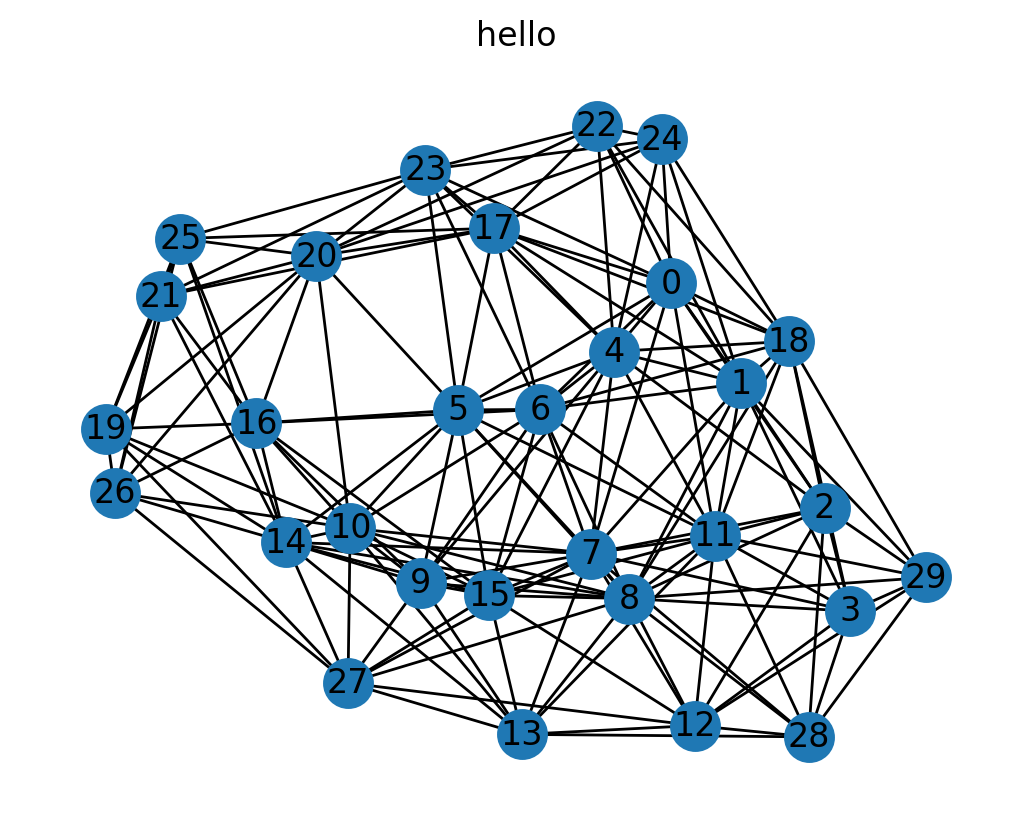

In [111]:
draw_graph(G,"hello")

In [112]:
list_node_features = []
list_edge_list = []
list_target_features = []
# list_edge_weights = []

for i in df["time"].unique():
    sub_df = df[df["time"] == i]
    G = nearest_neighbors_graph(sub_df, 8)
    
    node_features = [[G.nodes[node]['longitude'], G.nodes[node]['latitude'], 
                      G.nodes[node]['temperature'], G.nodes[node]['humidity'], G.nodes[node]['wind_speed'],
                      G.nodes[node]['wind_direction']]
                     for node in G.nodes]
    
    list_node_features.append(node_features)
    # Append other lists accordingly
    edge_list = [(edge[0], edge[1]) for edge in G.edges]
    edge_list += [(edge[1], edge[0]) for edge in G.edges]
    list_edge_list.append(edge_list)

    target_features = [ G.nodes[node]["pm"]
                     for node in G.nodes]
    list_target_features.append(target_features)

    # break

    


In [113]:
np.array(list_edge_list).shape

(8760, 336, 2)

In [137]:
list_edge_list_shape = np.array(list_edge_list).shape
list_edge_weights = list(np.ones(shape=(list_edge_list_shape[0],list_edge_list_shape[1],1)))

In [138]:
dataset = StaticGraphTemporalSignal(edge_index= np.array(list_edge_list[0]).T, features=np.array(list_node_features), targets=np.array(list_target_features), edge_weight=np.array(list_edge_weights[0]).squeeze())

In [139]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.recurrent2 = EvolveGCNH(node_count, dim_in)
        # self.bn1 = torch.nn.BatchNorm1d(dim_in)
        # self.bn2 = torch.nn.BatchNorm1d(dim_in)
        self.dropout = torch.nn.Dropout(0.4)

        self.linear = torch.nn.Linear(dim_in, 2)
        self.linear_2 = torch.nn.Linear(2, 1)
    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        # h = self.bn(h)
        h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.dropout(h)
        # h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.linear(h)
        h = self.linear_2(h)
        return h

In [140]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [141]:
for i in dataset:
    print(i)
    break

Data(x=[30, 6], edge_index=[2, 336], edge_attr=[336], y=[30])


In [142]:
model = TemporalGNN(dataset[0].x.shape[0],dataset[0].x.shape[1])

In [143]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        snapshot = snapshot
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean((y_pred - snapshot.y)**2)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 100/100 [13:36<00:00,  8.16s/it]


In [146]:
model.eval()
loss = 0
y_pred_list = []
for i, snapshot in enumerate(test_dataset):
    snapshot = snapshot
    y_pred = model(snapshot.x, snapshot.edge_index,snapshot.edge_attr)
    y_pred_list.append(y_pred)
    mse = torch.mean(torch.tensor((y_pred.detach().cpu().reshape(-1,1)-snapshot.y.detach().cpu().reshape(-1,1))**2).sqrt())
    print(mse)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_13714/48650622.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = torch.mean(torch.tensor((y_pred.detach().cpu().reshape(-1,1)-snapshot.y.detach().cpu().reshape(-1,1))**2).sqrt())


tensor(34.6193)
tensor(37.3622)
tensor(39.8761)
tensor(40.6740)
tensor(41.4124)
tensor(46.9713)
tensor(41.3026)
tensor(40.0743)
tensor(34.4456)
tensor(31.1590)
tensor(28.1165)
tensor(24.0551)
tensor(19.8360)
tensor(17.9073)
tensor(16.6219)
tensor(15.6699)
tensor(15.7374)
tensor(16.6450)
tensor(18.7637)
tensor(20.7327)
tensor(23.0657)
tensor(25.2372)
tensor(27.8194)
tensor(31.1363)
tensor(35.6526)
tensor(38.9404)
tensor(42.0899)
tensor(44.3388)
tensor(49.7061)
tensor(54.1611)
tensor(59.3244)
tensor(61.2846)
tensor(66.3215)
tensor(70.4690)
tensor(74.9756)
tensor(79.0681)
tensor(83.3783)
tensor(88.1108)
tensor(91.9363)
tensor(95.6136)
tensor(98.7516)
tensor(102.3936)
tensor(105.8127)
tensor(108.8103)
tensor(112.2225)
tensor(118.0908)
tensor(120.7149)
tensor(121.2052)
tensor(134.6772)
tensor(345.6784)
tensor(347.3929)
tensor(270.3126)
tensor(228.5380)
tensor(204.3035)
tensor(218.6356)
tensor(228.5544)
tensor(228.1651)
tensor(236.2428)
tensor(246.9825)
tensor(222.0779)
tensor(179.1741)
tens

In [149]:
y_pred_list[0].shape

torch.Size([30, 1])

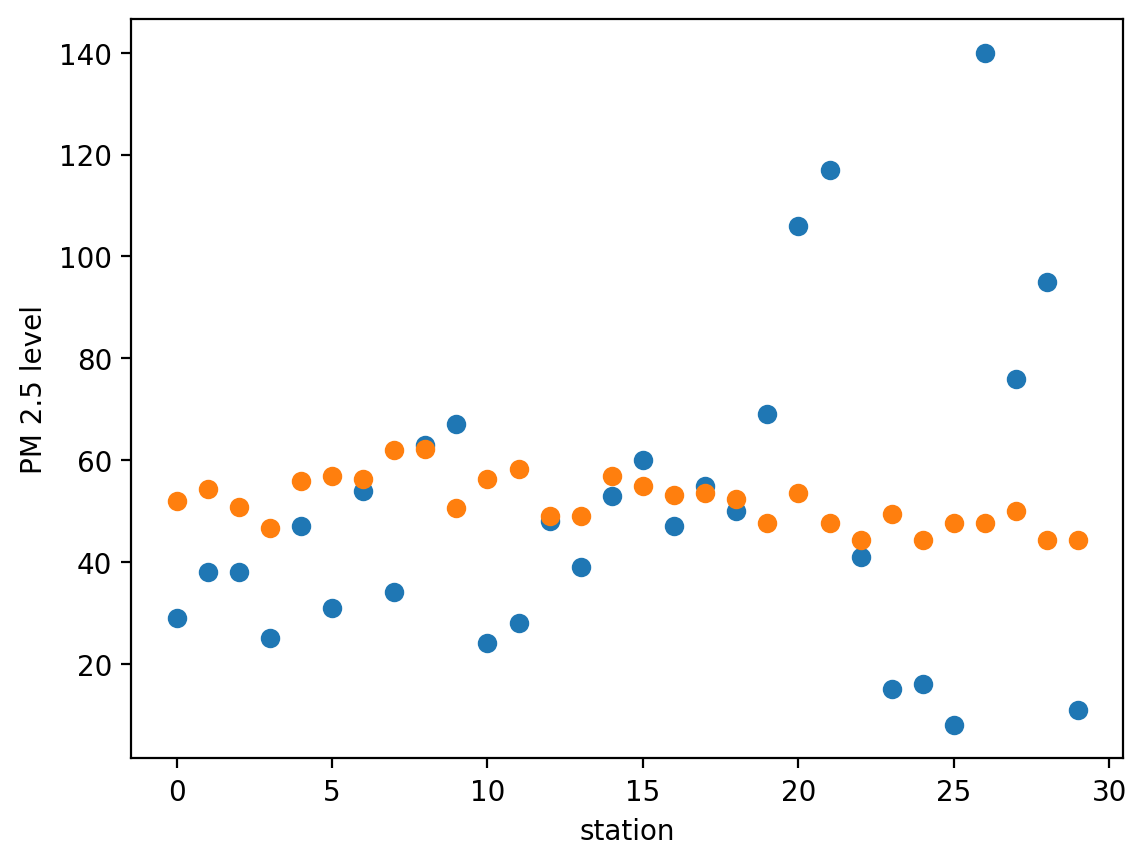

In [161]:
plt.scatter(np.arange(0,30),test_dataset[300].y)
plt.scatter(np.arange(0,30),y_pred_list[300].detach().numpy())
plt.ylabel("PM 2.5 level")
plt.xlabel("station")
plt.show();